In [367]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import copy


#gnerates 3D data. The network will predict z from x and y.
datapoints = 3000

#the function which will generate the z coordinate from x and y in the data (no outliers for now)
def f(x, y):
    return y ** 2 + np.cos(5*x)

data = []
for i in range(datapoints):
    data.append(np.random.uniform(0, 1, size = 2))
    
for i in range(len(data)):
    data[i] = np.append(data[i], f(data[i][0], data[i][1]))

data = np.array(data)

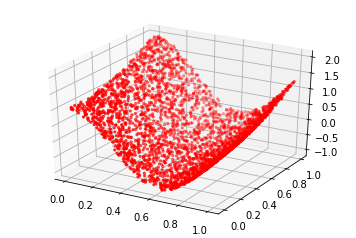

In [368]:
#a plot of the data

xs = data[:,0]
ys = data[:,1]
zs = data[:,2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs, c='r', marker = '.')

In [372]:
#learning parameters
learningrate = 0.05
number_epochs = 5
test_proportion = 0.8

#separates test data from training data
train_data = data[0:int(test_proportion * len(data))]
test_data = data[int(test_proportion * len(data)):len(data)]

#the neural network class
class neural_network(object):
    def __init__(self):
        self.weights_first_layer = np.random.normal(size = (10, 2))
        self.biases_first_layer = np.random.normal(size = (10, 1))

        self.weights_second_layer = np.random.normal(size = (10, 10))
        self.biases_second_layer = np.random.normal(size = (10, 1))

        self.weights_third_layer = np.random.normal(size = (10, 10))
        self.biases_third_layer = np.random.normal(size = (10, 1))

        self.weights_fourth_layer = np.random.normal(size = (1, 10))
        self.biases_fourth_layer = np.random.normal(size = 1)
        
    #calculates a z from an [x, y] vector based on current weights and biases of the network
    def calculate(self, x):
        l1 = np.matmul(self.weights_first_layer, x) + self.biases_first_layer
        l1 = np.tanh(l1)
        l2 = np.matmul(self.weights_second_layer, l1) + self.biases_second_layer
        l2 = np.tanh(l2)
        l3 = np.matmul(self.weights_third_layer, l2) + self.biases_third_layer
        l3 = np.tanh(l3)
        l4 = np.matmul(self.weights_fourth_layer, l3) + self.biases_fourth_layer
        l4 = np.tanh(l4)
        
        return l1, l2, l3, l4
    
    #the learning algorithm, performs backpropagation on the data and updates the weights/biases
    def learn(self, data):
        for epoch in range(number_epochs):
            loss = 0
            for point in data:
                pt = np.array([[point[0], point[1]]]).T
                l1, l2, l3, l4 = self.calculate(pt)
                y = point[2]
                error = (l4 - y)**2

                final_delta = 2*(l4 - y)*(1 - l4**2)           

                delta_3 = (np.array([np.ones(len(l3))]).T - l3**2) * self.weights_fourth_layer.T *  final_delta[0][0]
                delta_2 = (np.array([np.ones(len(l2))]).T - l2**2) * np.matmul(self.weights_third_layer.T, delta_3)
                delta_1 = (np.array([np.ones(len(l1))]).T - l1**2) * np.matmul(self.weights_second_layer.T, delta_2)

                self.weights_first_layer -= learningrate * np.matmul(delta_1, pt.T)
                self.weights_second_layer -= learningrate * np.matmul(delta_2, l1.T)
                self.weights_third_layer -= learningrate * np.matmul(delta_3, l2.T)
                self.weights_fourth_layer -= learningrate * np.matmul(final_delta, l3.T)
                
                self.biases_first_layer -= learningrate * delta_1
                self.biases_second_layer -= learningrate * delta_2
                self.biases_third_layer -= learningrate * delta_3
                self.biases_fourth_layer -= learningrate * final_delta[0]
                                
                loss += error
            print("EPOCH LOSS: ", loss)
            
    #a function for testing on a set of test data, which returns mean squared error
    def test(self, data):
        MSE = 0
        for point in data:
            pt = np.array([[point[0], point[1]]]).T
            l1, l2, l3, l4 = self.calculate(pt)
            y = point[2]
            squared_error = (y - l4)**2
            MSE += squared_error
        MSE = MSE/len(data)
        return MSE

In [373]:
#define the network
network = neural_network()

In [374]:
#trained on our training data
network.learn(train_data)

EPOCH LOSS:  [[770.01820475]]
EPOCH LOSS:  [[164.70473241]]
EPOCH LOSS:  [[109.16531989]]
EPOCH LOSS:  [[96.02997401]]
EPOCH LOSS:  [[91.48453731]]


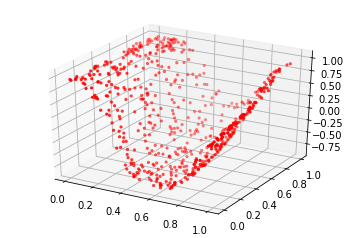

In [375]:
#predicts z coordinates for our test data
predictions = []
for point in test_data:
    pt = np.array([[point[0], point[1]]]).T
    prediction = network.calculate(pt)[-1][0][0]
    predictions.append(prediction)
    
#a plot of the predictions of the test data - as you can see the network worked!
xs = test_data[:,0]
ys = test_data[:,1]
zs = predictions

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs, c='r', marker = '.')

In [376]:
#mean squared error on test data
MSE = network.test(test_data)
print("TEST MEAN SQUARED ERROR: ", MSE)

TEST MEAN SQUARED ERROR:  [[0.04200008]]


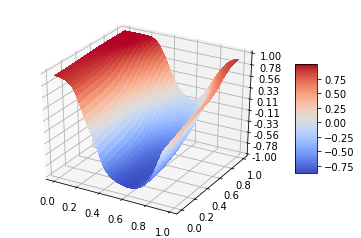

In [377]:
#and a plot of the surface created by the neural network - pretty close!
fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.arange(0, 1, 0.01)
Y = np.arange(0, 1, 0.01)
X, Y = np.meshgrid(X, Y)
Z = X.copy()
for i in range(len(X)):
    for j in range(len(X[i])):
        Z[i][j] = network.calculate(np.array([[X[i][j], Y[i][j]]]).T)[-1][0][0]


surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1, 1)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()
